In [2]:
import scipy.io
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow import keras

In [4]:
#path = '/gdrive/My Drive/Colab Notebooks/PhD/22_Realistic_pipe_ML/input/'

In [5]:
from pathlib import Path



In [6]:
#mode = 'Timelapse' # Use timelapse data for training and prediction
mode = 'Instant' # Use single acquisition for training and prediction
dynamic_nn = False # Automaticly scale network and encoding dim to size of input

sample_save = False # Save samples (only relevant to timelapse)
sample_load = True # Load samples (only relevant to timelapse)

autoencoder_save = True # Save the autoencoder
autoencoder_load = False # Load the autoencoder (to avoid rerunning)
#sensorindex = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] # Index of sensors to use
#sensorindex = [0, 3, 9, 12] # Index of sensors to use
#sensorindex = [0, 12]
sensorindex = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

timesamples = 640 # Number of time samples used in training. Fast time window length.

lastacq_only = True # Keep only last acquisition for training. Only relevant for Timelapse mode

noisedb = -12

In [7]:
#clock positions
mat = scipy.io.loadmat(Path().joinpath('..','data', 'input_simulated','trace_pos_clock_v7_rot_overlap.mat'))
X = mat['trace_pos_clock'].astype('float32')

In [8]:
#cm positions
#mat = scipy.io.loadmat(path + 'trace_pos_cm_v7_rot.mat')
#X = mat['trace_pos_cm']

In [9]:
X = np.swapaxes(X, 2, 1)
X.dtype, X.shape

(dtype('float32'), (2800, 13, 750))

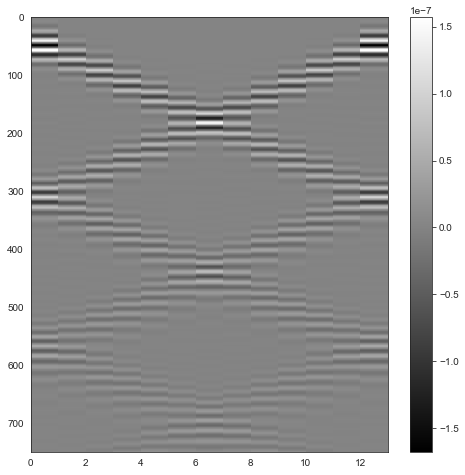

In [10]:
sns.set_style('white')
plt.figure(figsize=(8,8))

plt.pcolormesh(X[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()

In [11]:
X.shape[-1]

750

In [12]:
time_scaling = np.sqrt(np.arange(1, X.shape[-1]+1, dtype='float32'))
time_scaling = np.expand_dims(time_scaling, -1).T
time_scaling.shape

(1, 750)

In [13]:
time_scaling.dtype

dtype('float32')

In [14]:
X = np.multiply(X, time_scaling)

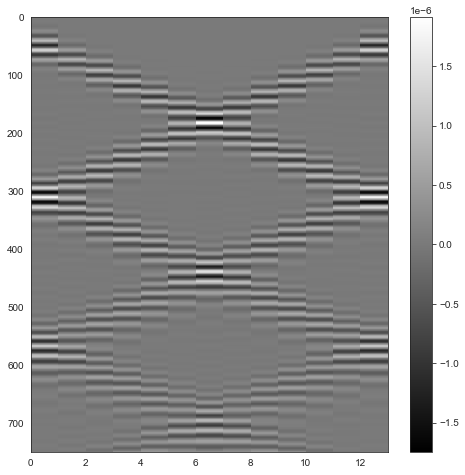

In [15]:
plt.figure(figsize=(8,8))
plt.pcolormesh(X[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()

In [16]:
labels = pd.read_csv(Path().joinpath('..', 'data', 'input_simulated', 'labels_rot.csv'))

In [17]:
labels

,modelname,thickness,seed,depression,pitting,depression_mu,depression_sigma,thickness_max,thickness_min,thickness_mean,thickness_median,thickness_std,thickness_var
0,model_t032_s101_d000_p002,32,101,0,2,1756.336829,278.267035,32,30,31.046875,31.0,0.725872,0.526890
1,model_t032_s101_d000_p004,32,101,0,4,1756.336829,278.267035,32,28,30.436343,31.0,1.152609,1.328508
2,model_t032_s101_d000_p006,32,101,0,6,1756.336829,278.267035,32,26,30.138310,30.0,1.457739,2.125004
3,model_t032_s101_d000_p008,32,101,0,8,1756.336829,278.267035,32,24,30.029514,30.0,1.624967,2.640518
4,model_t032_s101_d000_p010,32,101,0,10,1756.336829,278.267035,32,22,29.994792,30.0,1.699060,2.886804
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,model_t040_s116_d024_p002,40,116,24,2,1512.291398,189.482963,40,14,35.737847,39.0,6.787417,46.069027
2796,model_t040_s116_d024_p004,40,116,24,4,1512.291398,189.482963,40,12,35.088831,38.0,6.839524,46.779082
2797,model_t040_s116_d024_p006,40,116,24,6,1512.291398,189.482963,40,10,34.801505,38.0,6.913646,47.798504
2798,model_t040_s116_d024_p008,40,116,24,8,1512.291398,189.482963,40,10,34.721065,38.0,6.935825,48.105675


In [18]:
labels.rename(columns={'thickness':'Thickness',
                       'depression':'Depression depth', 
                       'pitting':'Pitting depth', 
                       'depression_mu':'Depression location',
                       'depression_sigma':'Depression width',
                       'thickness_max':'Thickness maximum',
                       'thickness_min':'Thickness minimum', 
                       'thickness_mean':'Thickness mean',
                       'thickness_median':'Thickness median',
                       'thickness_std':'Thickness std'}, inplace=True)

In [19]:
#temp_s102_t040 = labels[(labels['seed']==102) & (labels['thickness']==40)]

In [20]:
#temp_s102_t040

In [21]:
from acoustics import generator
def make_noise(noisedb, noiseshape):
  noise = np.zeros(noiseshape, dtype='float32')
  noiselev = 10**(noisedb/10)
  for i in range(noiseshape[0]):
    for j in range(noiseshape[1]):
      noise[i, j, :] = generator.noise(noiseshape[2], color='pink')*noiselev





  return noise

In [22]:
X.dtype

dtype('float32')

In [23]:
#testnoise = make_noise(-20, (10, 11, 640))
#testnoise.dtype

In [24]:
#plt.pcolormesh(testnoise[1, :, :].T)
#plt.colorbar()
#plt.show()

# Story mode

In [25]:
def make_sample(labels, s, thickness, num_traces=10):
  df = labels[(labels['seed']==s) & (labels['Thickness']==thickness)]
  #s = 102
  #thickness = 40
  #num_traces = 10
  dep_inc = 4
  pit_inc = 2
  random_picks = pd.DataFrame(columns=df.columns)
  random_picks = random_picks.append(df.iloc[0])
  while len(random_picks) < num_traces:
    last_depression = random_picks.iloc[-1]['Depression depth']
    last_pitting = random_picks.iloc[-1]['Pitting depth']
    development = np.random.choice(['quo', 'pit_increase', 'dep_increase'], p=[0.5, 0.2, 0.3])
    #print(development)
    if development == 'dep_increase':
      new_dep = last_depression + dep_inc
      new_pit = last_pitting
    elif development == 'pit_increase':
      new_pit = last_pitting + pit_inc
      new_dep = last_depression
    elif development == 'quo':
      new_pit = last_pitting
      new_dep = last_depression
  
    row = df[(df['Depression depth'] == new_dep) & (df['Pitting depth'] == new_pit) ]
    random_picks = random_picks.append(row)
  return random_picks

In [26]:
def make_samples(X, df, num_samples):
  
  labels_samples = pd.DataFrame(columns=df.columns)
  X_list_c = []
  X_list_n = []
  for i in range(num_samples):
    s = np.random.choice(df['seed'].unique())
    thickness = np.random.choice(df['Thickness'].unique())
    #print(s, thickness)
    df_temp = make_sample(labels=df, s=s, thickness=thickness, num_traces=10)
    #X_temp = X[df_temp.index, :,:640]/X.max()
    X_temp = X[df_temp.index, :,:timesamples]/X.max()
    #add noise###################################################################
    #print(X_temp.shape)
    X_list_c.append(X_temp)
    X_list_n.append(X_temp + make_noise(noisedb, X_temp.shape)) #noise changed from -20 to -12
    #X_list.append(X[df_temp.index, :640,:]/X.max())
    #print(df_temp['modelname'])
    labels_samples = labels_samples.append(df_temp.iloc[-1:])


                          
  return np.stack(X_list_c), np.stack(X_list_n), labels_samples.reset_index()


In [27]:
import pickle

In [28]:
if mode=='Timelapse':
  if sample_load:
    #load previously saved samples
    with open(path + 'X_sample_c.pickle', 'rb') as f:
      X_sample_c = pickle.load(f)
    with open(path + 'X_sample_n.pickle', 'rb') as f:
      X_sample_n = pickle.load(f)
    with open(path + 'label_sample.pickle', 'rb') as f:
      label_sample = pickle.load(f)

    #X_sample_c = pickle.load(path + 'X_sample_c.pickle')
    #X_sample_n = pickle.load(path + 'X_sample_n.pickle')
    #label_sample = pickle.load(path + 'label_sample.pickle')
    print('Samples loaded')
  else:
    X_sample_c, X_sample_n, label_sample = make_samples(X, labels, 2800)
    print('Samples generated')
    if sample_save:
      #Save generated samples
      with open(path + 'X_sample_c.pickle', 'wb') as f:
        pickle.dump(X_sample_c, f)
      with open(path + 'X_sample_n.pickle', 'wb') as f:
        pickle.dump(X_sample_n, f)
      with open(path + 'label_sample.pickle', 'wb') as f:
        pickle.dump(label_sample, f)
      print('Samples saved')
      


In [29]:
#stop

# Instant Mode

In [30]:

if mode=='Instant':
  X_sample_c = X[:,:,:timesamples]/X.max()
#  X_sample_c = X[:,:,:250]/X.max()
  X_sample_n = X_sample_c + make_noise(-20, X_sample_c.shape)
  label_sample = labels

  X_sample_n = np.expand_dims(X_sample_n, 1)
  X_sample_c = np.expand_dims(X_sample_c, 1)

In [31]:
X_sample_n.shape

(2800, 1, 13, 640)

In [32]:
#np.prod(X_sample.shape)

In [33]:
#X_sample.shape, label_sample.shape

In [34]:
X.max()

1.9439242e-06

# Subselecting Data

In [35]:
if lastacq_only:
  # Only last acquisition kept:
  X_sample_n = X_sample_n[:,-1,:,:]
  X_sample_c = X_sample_c[:,-1,:,:]

  X_sample_n = np.expand_dims(X_sample_n, 1)
  X_sample_c = np.expand_dims(X_sample_c, 1)

  X_sample_n.shape, X_sample_c.shape
  print('Only last acquisition kept')


Only last acquisition kept


In [36]:
def pick_sensors(X_sample, sensorindex):
  # Sparse sensor mode:
  X_sample = np.take(X_sample, sensorindex, axis=2)
  if len(sensorindex)==1:
    X_sample = np.expand_dims(X_sample, 2)
  return X_sample

In [37]:

X_sample_n = pick_sensors(X_sample_n, sensorindex)
X_sample_c = pick_sensors(X_sample_c, sensorindex)

In [38]:
X_sample_n.shape, X_sample_c.shape

((2800, 1, 11, 640), (2800, 1, 11, 640))

In [39]:
sns.set_style("white")

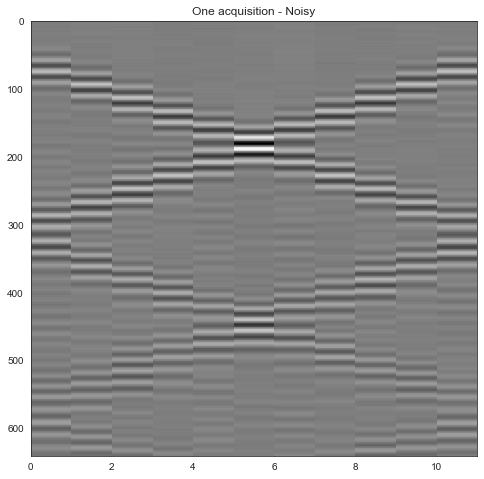

In [40]:
plt.figure(figsize=(8,8))
plt.pcolormesh(X_sample_n[1, 0,:, :].T, cmap='gray')
plt.gca().invert_yaxis()
plt.title('One acquisition - Noisy')


plt.show()

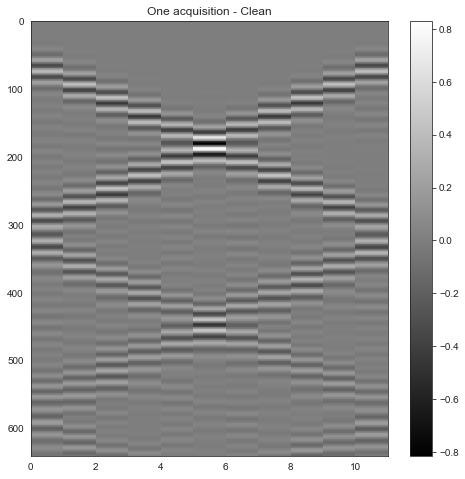

In [41]:
plt.figure(figsize=(8,8))

plt.pcolormesh(X_sample_c[1, 0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()
plt.title('One acquisition - Clean')

plt.show()

# Label attributes

In [42]:
import seaborn as sns
#sns.set_style('white')
#sns.set_context('talk')

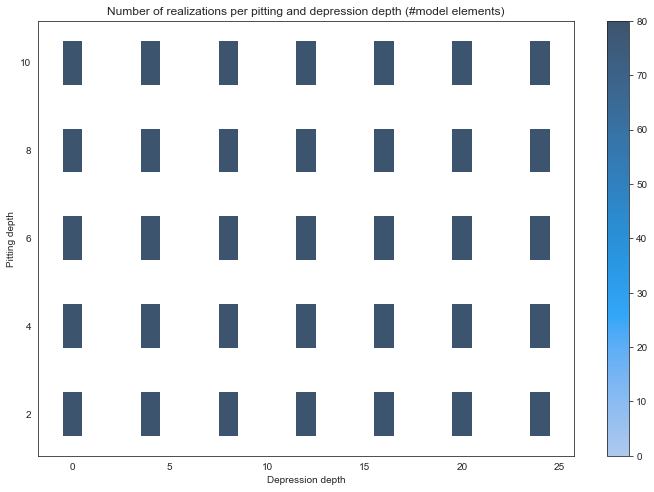

In [43]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Depression depth", y="Pitting depth", discrete=True, cbar=True)
#sns.histplot(data=label_sample, x="pitting", binwidth=1)
plt.title('Number of realizations per pitting and depression depth (#model elements)')
plt.show()

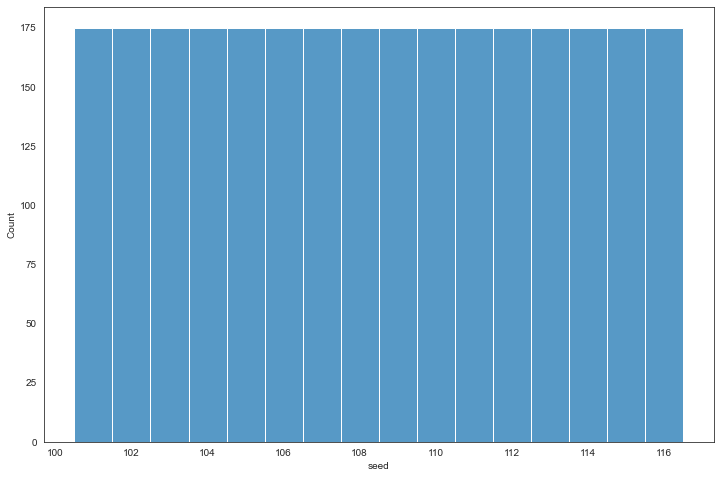

In [44]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="seed", discrete=True)

plt.show()

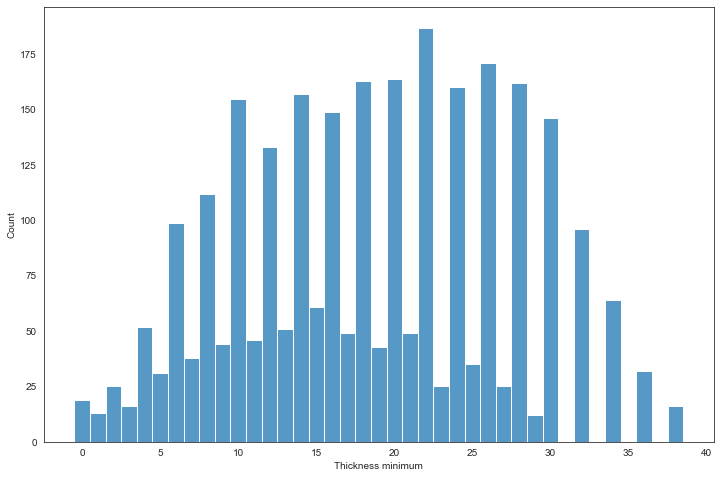

In [45]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Thickness minimum", discrete=True)

plt.show()

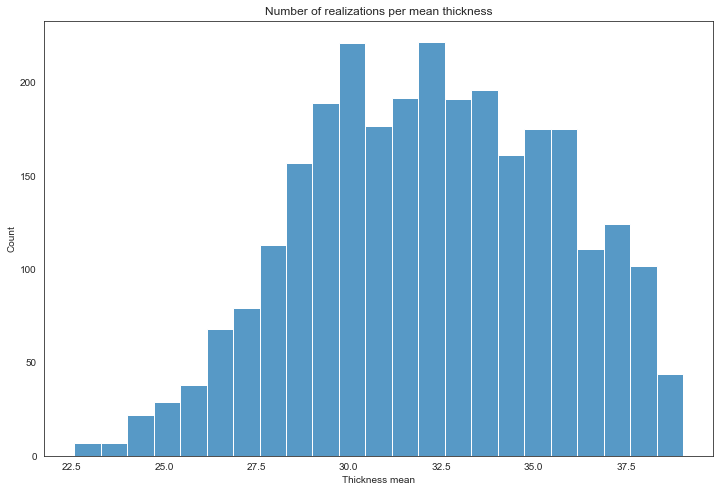

In [46]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Thickness mean")
plt.title("Number of realizations per mean thickness")
plt.show()

In [47]:
#stop

In [48]:
X_sample_c.shape, label_sample.shape

((2800, 1, 11, 640), (2800, 13))

# ML

In [49]:
x_train, x_test, y_train, y_test = train_test_split(X_sample_n, X_sample_c, test_size=0.2, random_state=42)

In [50]:
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
y_train_flat = y_train.reshape((len(y_train), np.prod(y_train.shape[1:])))
y_test_flat = y_test.reshape((len(y_test), np.prod(y_test.shape[1:])))

In [51]:
y_train.shape, y_test.shape

((2240, 1, 11, 640), (560, 1, 11, 640))

In [52]:
x_train_flat.shape[1], x_test_flat.shape

(7040, (560, 7040))

In [53]:
import keras
from keras import layers
#from keras import regularizers
#from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model
from keras.models import load_model

In [54]:
def make_autoencoder_ss(encoding_dim=64):

  input_trace = keras.Input(shape=(x_train_flat.shape[1],))
  # Add a Dense layer with a L1 activity regularizer
  encoded = layers.Dense(512, activation='tanh')(input_trace)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(256, activation='tanh')(encoded)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(128, activation='tanh')(encoded)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(encoding_dim, activation='tanh')(encoded)




  # "decoded" is the lossy reconstruction of the input
  decoded = layers.Dense(128, activation='tanh')(encoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(256, activation='tanh')(decoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(512, activation='tanh')(decoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(x_train_flat.shape[1], activation='linear')(decoded)

  # This model maps an input to its reconstruction
  autoencoder = keras.Model(input_trace, decoded)

  # This model maps an input to its encoded representation
  encoder = keras.Model(input_trace, encoded)

  # This is our encoded input
  encoded_input = keras.Input(shape=(encoding_dim,))
  deco = autoencoder.layers[-4](encoded_input)
  deco = autoencoder.layers[-3](deco)
  deco = autoencoder.layers[-2](deco)
  deco = autoencoder.layers[-1](deco)
  # create the decoder model
  decoder = keras.Model(encoded_input, deco)

  return autoencoder, encoder, decoder

In [55]:
def make_autoencoder(encoding_dim=64):

  input_trace = keras.Input(shape=(x_train_flat.shape[1],))
  # Add a Dense layer with a L1 activity regularizer
  encoded = layers.Dense(1024, activation='tanh')(input_trace)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(512, activation='tanh')(encoded)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(256, activation='tanh')(encoded)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(128, activation='tanh')(encoded)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(encoding_dim, activation='tanh')(encoded)




  # "decoded" is the lossy reconstruction of the input
  decoded = layers.Dense(128, activation='tanh')(encoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(256, activation='tanh')(decoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(512, activation='tanh')(decoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(1024, activation='tanh')(decoded)
  decoded = layers.Dense(x_train_flat.shape[1], activation='linear')(decoded)

  # This model maps an input to its reconstruction
  autoencoder = keras.Model(input_trace, decoded)

  # This model maps an input to its encoded representation
  encoder = keras.Model(input_trace, encoded)

  # This is our encoded input
  encoded_input = keras.Input(shape=(encoding_dim,))
  deco = autoencoder.layers[-5](encoded_input)
  deco = autoencoder.layers[-4](deco)
  deco = autoencoder.layers[-3](deco)
  deco = autoencoder.layers[-2](deco)
  deco = autoencoder.layers[-1](deco)
  # create the decoder model
  decoder = keras.Model(encoded_input, deco)

  return autoencoder, encoder, decoder

In [56]:
def make_autoencoder_flex(encoding_dim=64):

  input_trace = keras.Input(shape=(x_train_flat.shape[1],))
  # Add a Dense layer with a L1 activity regularizer
  encoded = layers.Dense(encoding_dim*16, activation='tanh')(input_trace)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(encoding_dim*8, activation='tanh')(encoded)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(encoding_dim*4, activation='tanh')(encoded)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(encoding_dim*2, activation='tanh')(encoded)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(encoding_dim, activation='tanh')(encoded)




  # "decoded" is the lossy reconstruction of the input
  decoded = layers.Dense(encoding_dim*2, activation='tanh')(encoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(encoding_dim*4, activation='tanh')(decoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(encoding_dim*8, activation='tanh')(decoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(encoding_dim*16, activation='tanh')(decoded)
  decoded = layers.Dense(x_train_flat.shape[1], activation='linear')(decoded)

  # This model maps an input to its reconstruction
  autoencoder = keras.Model(input_trace, decoded)

  # This model maps an input to its encoded representation
  encoder = keras.Model(input_trace, encoded)

  # This is our encoded input
  encoded_input = keras.Input(shape=(encoding_dim,))
  deco = autoencoder.layers[-5](encoded_input)
  deco = autoencoder.layers[-4](deco)
  deco = autoencoder.layers[-3](deco)
  deco = autoencoder.layers[-2](deco)
  deco = autoencoder.layers[-1](deco)
  # create the decoder model
  decoder = keras.Model(encoded_input, deco)

  return autoencoder, encoder, decoder

In [57]:
#stop

In [58]:
x_train_flat.shape[1]//1040

6

Epoch 1/100
9/9 [==============================] - 3s 302ms/step - loss: 0.0131 - val_loss: 0.0100
Epoch 2/100
9/9 [==============================] - 3s 292ms/step - loss: 0.0081 - val_loss: 0.0061
Epoch 3/100
9/9 [==============================] - 2s 257ms/step - loss: 0.0055 - val_loss: 0.0048
Epoch 4/100
9/9 [==============================] - 2s 250ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 5/100
9/9 [==============================] - 3s 292ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 6/100
9/9 [==============================] - 2s 267ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/100
9/9 [==============================] - 2s 242ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 8/100
9/9 [==============================] - 3s 297ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 9/100
9/9 [==============================] - 3s 277ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 10/100
9/9 [==============================] - 2s 254ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 11/

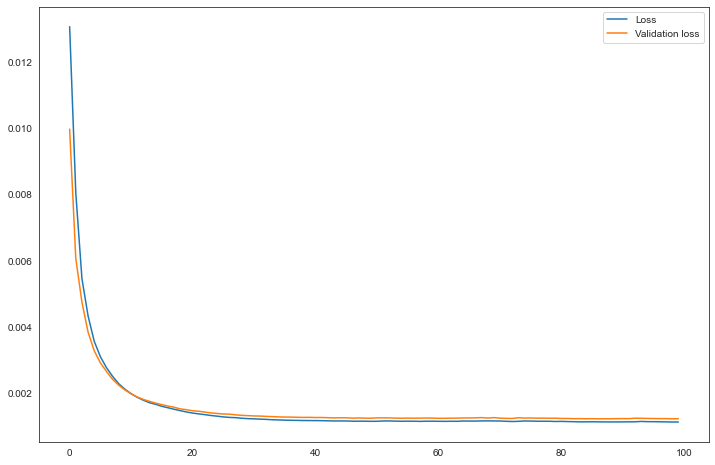

In [59]:
#encoding_dim = 64
if dynamic_nn:
  encoding_dim = x_train_flat.shape[1]//1040 #Originally: 130
else:
  encoding_dim = 64
  
if autoencoder_load:
  autoencoder = load_model(path + 'autoencoder.h5')
  encoder = load_model(path + 'encoder.h5')
  decoder = load_model(path + 'decoder.h5')
else:
  #autoencoder, encoder, decoder = make_autoencoder_ss(encoding_dim=encoding_dim) #single sensor autoencoder
  autoencoder, encoder, decoder = make_autoencoder_flex(encoding_dim=encoding_dim)
  autoencoder.compile(optimizer='adam', loss='mse')

  history = autoencoder.fit(x_train_flat, y_train_flat,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_flat, y_test_flat))
  
  #sns.set_style('whitegrid')
  plt.figure(figsize=(12, 8))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Loss', 'Validation loss'])
  plt.show()


In [60]:
plot_model(autoencoder, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [61]:
plot_model(encoder, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [62]:
plot_model(decoder, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [63]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7040)]            0         
                                                                 
 dense (Dense)               (None, 1024)              7209984   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 128)               8320  

In [64]:
if autoencoder_save:
  autoencoder.save(Path().joinpath('..', 'models', 'autoencoder_11pos.h5'))
  encoder.save(Path().joinpath('..', 'models', 'encoder_11pos.h5'))
  decoder.save(Path().joinpath('..', 'models', 'decoder_11pos.h5'))

In [65]:
decoded_traces = autoencoder.predict(x_test_flat)
encoded_traces = encoder.predict(x_test_flat)

In [66]:
encoded_traces.shape, decoded_traces.shape

((560, 64), (560, 7040))

In [67]:
y_test.shape

(560, 1, 11, 640)

In [68]:

test_decoded_shaped = decoded_traces.reshape(len(decoded_traces), y_test.shape[1], y_test.shape[2], y_test.shape[3]) #Should alway work


In [69]:
y_test.shape

(560, 1, 11, 640)

In [70]:
x_test.shape, test_decoded_shaped.shape

((560, 1, 11, 640), (560, 1, 11, 640))

In [71]:
#x_test_shaped = x_test.reshape(len(x_test), 10, 11, 640)

In [72]:
#label_sample

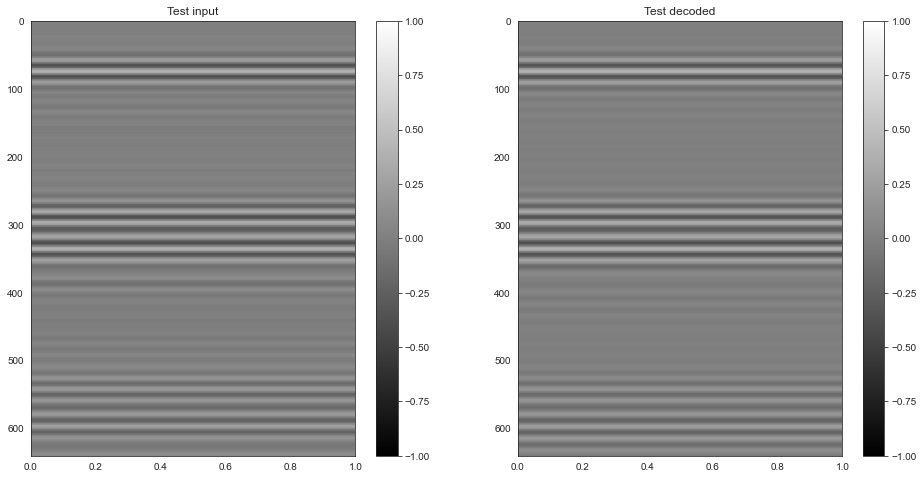

In [73]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.pcolormesh(x_test[1, :,0, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test input')

plt.subplot(1, 2, 2)
plt.pcolormesh(test_decoded_shaped[1, :,0, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test decoded')



plt.show()

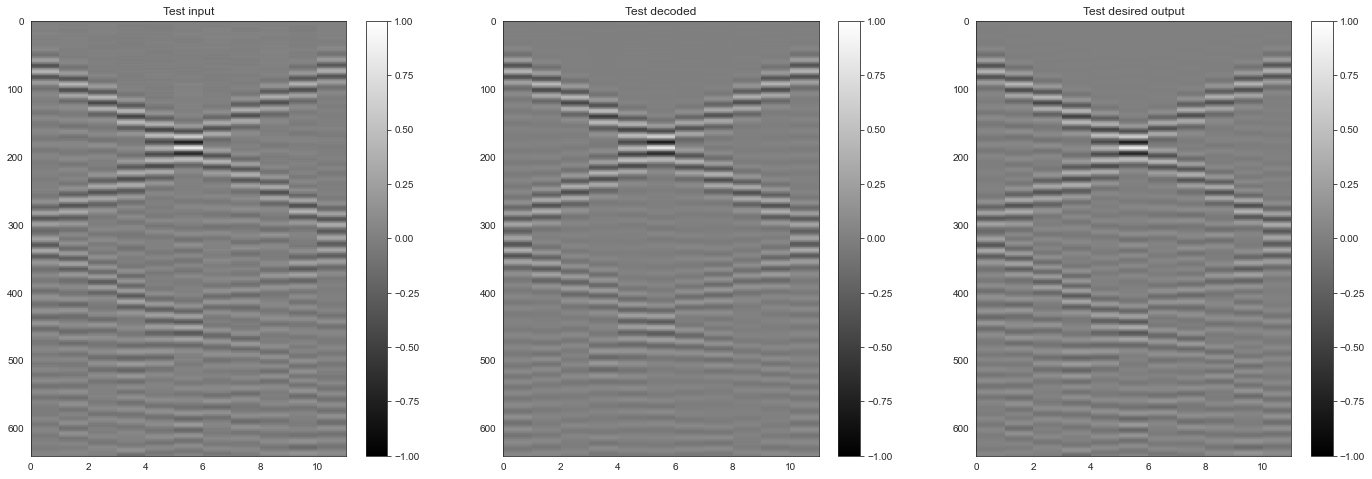

In [74]:
plt.figure(figsize=(24,8))

plt.subplot(1, 3, 1)
plt.pcolormesh(x_test[0, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test input')

plt.subplot(1, 3, 2)
plt.pcolormesh(test_decoded_shaped[0, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test decoded')

plt.subplot(1, 3, 3)
plt.pcolormesh(y_test[0, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test desired output')



plt.show()

In [75]:
x_test.dtype, test_decoded_shaped.dtype, encoded_traces.dtype

(dtype('float32'), dtype('float32'), dtype('float32'))

In [76]:
#Save volumes for display in plotly
#np.save(path + 'x_test.npy', x_test)
#np.save(path + 'test_decoded_shaped.npy', test_decoded_shaped)

In [77]:
autoencoder.evaluate(x_test_flat, x_test_flat)

18/18 [==============================] - 0s 14ms/step - loss: 0.0013


0.0013267801841720939

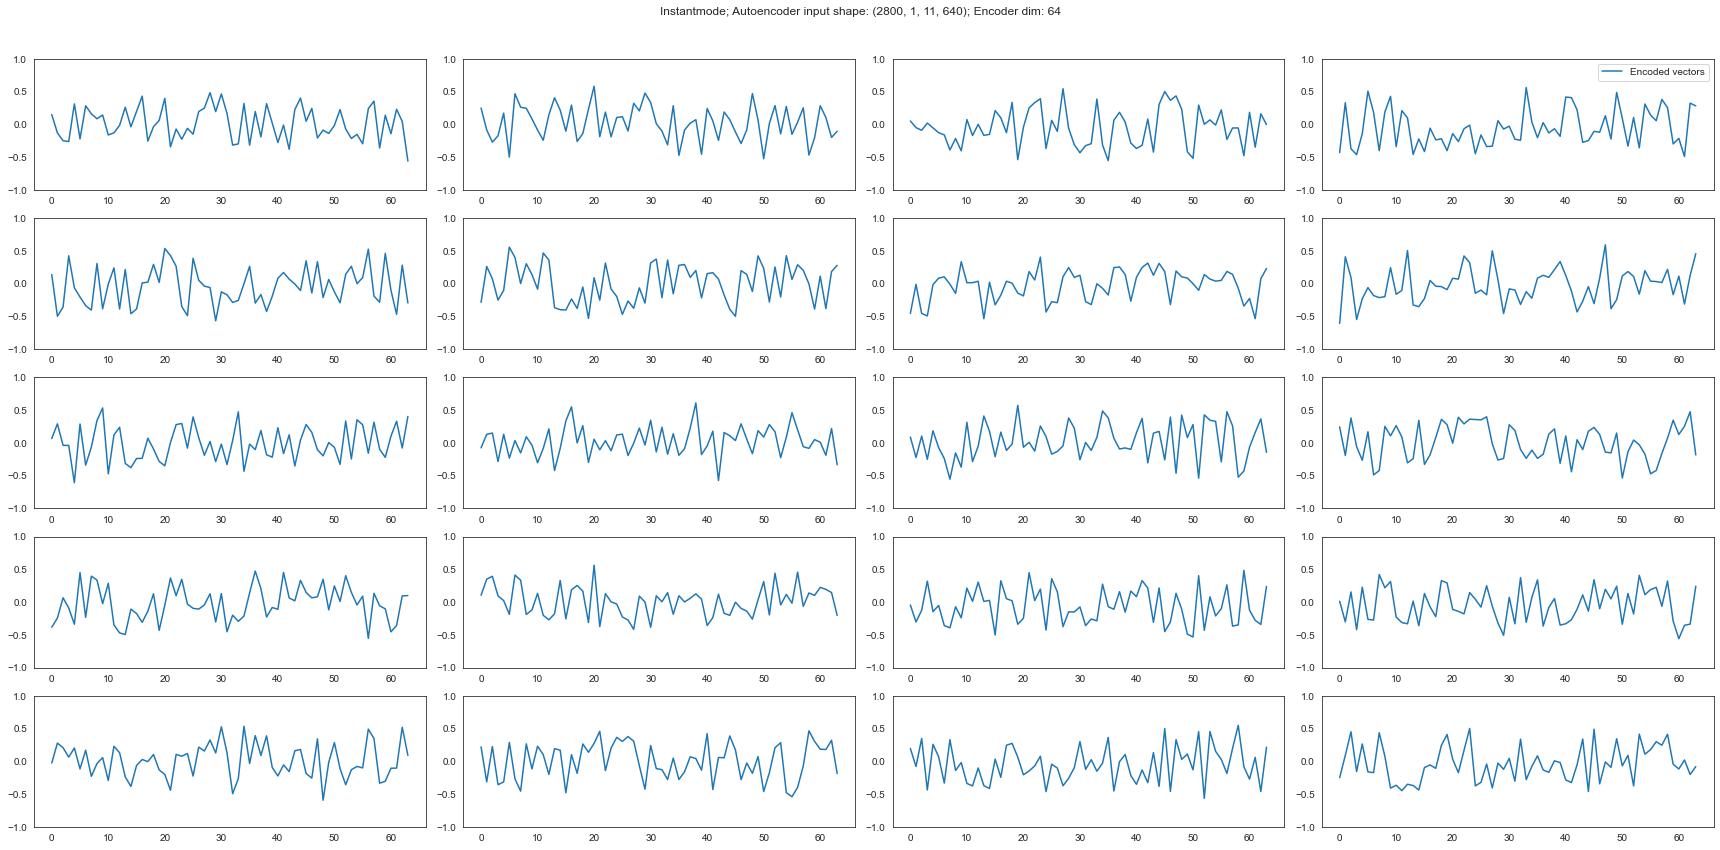

In [78]:
xnum = 5
ynum = 4
n = xnum*ynum

plt.figure(figsize=(24, 12))
for i in range(n):
    ax = plt.subplot(xnum, ynum, i + 1)
    
    #plt.plot(x_test_in[i])
    plt.plot(encoded_traces[i])
    #plt.plot(x_test_in[i])
    if i==ynum-1:
      #plt.legend(['Input trace', 'Decoded trace'], loc=1)
      plt.legend(['Encoded vectors'], loc=1)
    plt.ylim([-1, 1])

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle(mode+'mode'+'; Autoencoder input shape: '+ str(X_sample_n.shape) + '; Encoder dim: ' + str(encoding_dim), fontsize=12)
plt.show()

# Regression

In [79]:
X_sample_flat = X_sample_n.reshape((len(X_sample_n), np.prod(X_sample_n.shape[1:])))

In [80]:
X_sample_flat.shape

(2800, 7040)

In [81]:
encoded_all = encoder.predict(X_sample_flat)

In [82]:
encoded_all.shape

(2800, 64)

In [83]:
label_sample.columns

Index(['modelname', 'Thickness', 'seed', 'Depression depth', 'Pitting depth',
       'Depression location', 'Depression width', 'Thickness maximum',
       'Thickness minimum', 'Thickness mean', 'Thickness median',
       'Thickness std', 'thickness_var'],
      dtype='object')

In [84]:


attributes = ['Thickness mean','Thickness minimum', 'Thickness std', 'Depression depth', 'Depression location','Pitting depth']


In [85]:
label_sample

,modelname,Thickness,seed,Depression depth,Pitting depth,Depression location,Depression width,Thickness maximum,Thickness minimum,Thickness mean,Thickness median,Thickness std,thickness_var
0,model_t032_s101_d000_p002,32,101,0,2,1756.336829,278.267035,32,30,31.046875,31.0,0.725872,0.526890
1,model_t032_s101_d000_p004,32,101,0,4,1756.336829,278.267035,32,28,30.436343,31.0,1.152609,1.328508
2,model_t032_s101_d000_p006,32,101,0,6,1756.336829,278.267035,32,26,30.138310,30.0,1.457739,2.125004
3,model_t032_s101_d000_p008,32,101,0,8,1756.336829,278.267035,32,24,30.029514,30.0,1.624967,2.640518
4,model_t032_s101_d000_p010,32,101,0,10,1756.336829,278.267035,32,22,29.994792,30.0,1.699060,2.886804
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,model_t040_s116_d024_p002,40,116,24,2,1512.291398,189.482963,40,14,35.737847,39.0,6.787417,46.069027
2796,model_t040_s116_d024_p004,40,116,24,4,1512.291398,189.482963,40,12,35.088831,38.0,6.839524,46.779082
2797,model_t040_s116_d024_p006,40,116,24,6,1512.291398,189.482963,40,10,34.801505,38.0,6.913646,47.798504
2798,model_t040_s116_d024_p008,40,116,24,8,1512.291398,189.482963,40,10,34.721065,38.0,6.935825,48.105675


In [86]:
def make_regression_model():
  model = Sequential()
  model.add(Dense(encoding_dim, activation='tanh'))
  if encoding_dim > 32:
    model.add(Dense(32, activation='tanh'))
  if encoding_dim > 24:
    model.add(Dense(24, activation='tanh'))
  if encoding_dim > 16:
    model.add(Dense(16, activation='tanh'))
  if encoding_dim > 8:
    model.add(Dense(8, activation='tanh'))
  model.add(Dense(4, activation='tanh'))
  model.add(Dense(1, activation='linear'))
  return model

Thickness mean


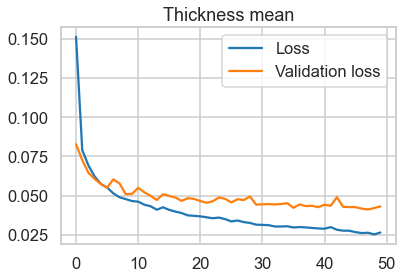

18/18 [==============================] - 0s 2ms/step - loss: 0.0431
loss: 0.04308838024735451
Thickness minimum


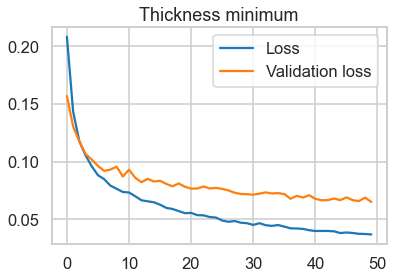

18/18 [==============================] - 0s 2ms/step - loss: 0.0651
loss: 0.0650954395532608
Thickness std


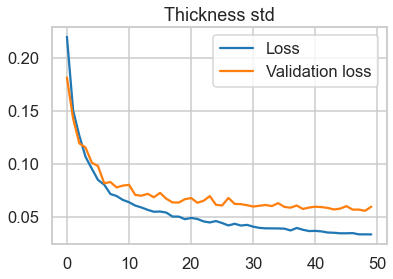

18/18 [==============================] - 0s 2ms/step - loss: 0.0597
loss: 0.059746645390987396
Depression depth


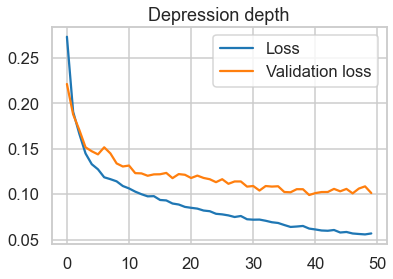

18/18 [==============================] - 0s 2ms/step - loss: 0.1011
loss: 0.10114758461713791
Depression location


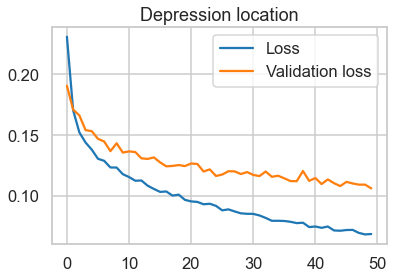

18/18 [==============================] - 0s 1ms/step - loss: 0.1063
loss: 0.10631182044744492
Pitting depth


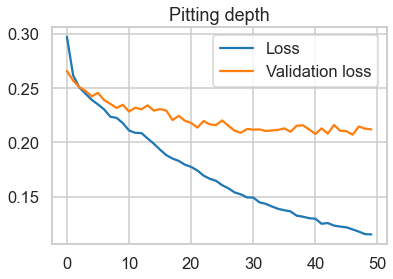

18/18 [==============================] - 0s 2ms/step - loss: 0.2120
loss: 0.21202640235424042


In [236]:
sns.set_style('whitegrid')
df_loss = pd.DataFrame(columns=attributes)
df_test = pd.DataFrame(columns=attributes)
df_predict = pd.DataFrame(columns=attributes)
regression_models = {}
min_max_scalers = {}
for attribute in attributes:
  print(attribute)
  y_reg = label_sample[[attribute]]

  min_max_scaler = MinMaxScaler()
  y_reg = min_max_scaler.fit_transform(y_reg)
  x_reg_train, x_reg_test, y_reg_train, y_reg_test_norm = train_test_split(encoded_all, y_reg, test_size=0.2, random_state=42)
  regression_model = make_regression_model()
  regression_model.compile(loss='mae', optimizer='adam')
  history = regression_model.fit(x_reg_train, y_reg_train.astype('float32'),
                epochs=50,
                batch_size=20,
                shuffle=True,
                verbose=0,
                validation_data=(x_reg_test, y_reg_test_norm.astype('float32')))
  
  plt.figure(figsize=(6, 4))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Loss', 'Validation loss'])
  plt.title(attribute)
  plt.show()

  y_predict_norm = regression_model.predict(x_reg_test)
  y_predict = min_max_scaler.inverse_transform(y_predict_norm)
  y_reg_test = min_max_scaler.inverse_transform(y_reg_test_norm)
  loss = regression_model.evaluate(x_reg_test, y_reg_test_norm)
  print("loss: " + str(loss))
  df_loss.at[0, attribute] = loss
  df_test[attribute] = np.squeeze(y_reg_test)
  df_predict[attribute] = np.squeeze(y_predict)
  regression_models[attribute] = regression_model
  min_max_scalers[attribute] = min_max_scaler

In [237]:
df_loss

,Thickness mean,Thickness minimum,Thickness std,Depression depth,Depression location,Pitting depth
0,0.043088,0.065095,0.059747,0.101148,0.106312,0.212026


In [191]:
df_predict

,Thickness mean,Thickness minimum,Thickness std,Depression depth,Depression location,Pitting depth
0,31.725422,23.272095,1.240420,-0.410068,1430.253662,9.261341
1,31.852160,28.875957,1.428188,-0.920791,1449.901611,5.277431
2,31.150995,12.277773,7.598924,19.422241,1172.287964,2.951245
3,33.857304,30.985123,1.538342,0.805216,1414.768188,5.421849
4,31.441639,11.957903,6.743632,21.864185,995.150452,6.638430
...,...,...,...,...,...,...
555,31.209179,19.333078,2.705451,8.624425,1526.684814,7.554794
556,31.196592,7.851196,3.349434,18.952248,2232.940674,8.730406
557,30.256739,5.781196,7.290691,18.852650,1126.782593,2.553589
558,31.545168,26.100704,1.487618,-0.259872,1044.915405,4.167361


In [192]:
'''history = regression_model.fit(x_reg_train, y_reg_train.astype('float32'),
                epochs=50,
                batch_size=20,
                shuffle=True,
                validation_data=(x_reg_test, y_reg_test_norm.astype('float32')))
                '''

"history = regression_model.fit(x_reg_train, y_reg_train.astype('float32'),\n                epochs=50,\n                batch_size=20,\n                shuffle=True,\n                validation_data=(x_reg_test, y_reg_test_norm.astype('float32')))\n                "

In [193]:
plot_model(regression_model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [194]:
regression_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87 (Dense)            (None, 64)                4160      
                                                                 
 dense_88 (Dense)            (None, 32)                2080      
                                                                 
 dense_89 (Dense)            (None, 24)                792       
                                                                 
 dense_90 (Dense)            (None, 16)                400       
                                                                 
 dense_91 (Dense)            (None, 8)                 136       
                                                                 
 dense_92 (Dense)            (None, 4)                 36        
                                                                 
 dense_93 (Dense)            (None, 1)               

In [195]:
def plot_pred(fno, title):
  dy = 0.2
  plt.figure(figsize=(8, 8))
  plt.scatter(dy*y_reg_test[:,fno], dy*y_predict[:,fno], alpha=0.3)
  plt.plot([dy*y_reg_test[:,fno].min(), dy*y_reg_test[:,fno].max()], [dy*y_reg_test[:,fno].min(), dy*y_reg_test[:,fno].max()], 'r--' )
  plt.title('Predicted vs true label: ' + title)
  plt.xlabel('True [mm]')
  plt.ylabel('Predicted [mm]')
  plt.grid()
  plt.show()

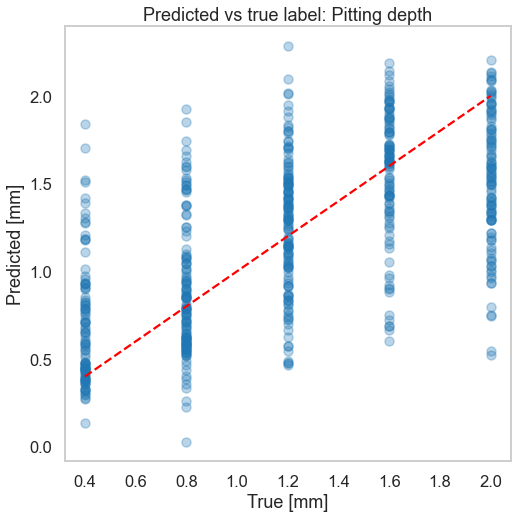

In [196]:
plot_pred(0, attribute)

In [197]:
scales = np.array([[4.5, 8],
                   [-0.5, 8],
                   [0, 1.8],
                   [-0.5, 5.5],
                   [150, 550],
                   [0, 2.25]])
df_scales = pd.DataFrame(scales.T, columns=df_test.columns)

In [198]:
#import latex

In [199]:
X_sample_n.shape

(2800, 1, 11, 640)

In [200]:
dy = 0.2
def plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=True):
  sns.set_style('whitegrid')
  sns.set_context('talk')
  attributes = df_test.columns
  plt.figure(figsize=(20, 12))
  for i, attribute in enumerate(attributes):
    y_test_merge = np.squeeze(np.stack([df_test[[attribute]].to_numpy(), df_predict[[attribute]].to_numpy()]))*dy
    df_test_merge = pd.DataFrame(y_test_merge.T, columns=['True [mm]', 'Predicted [mm]'])
    df_test_merge['abs_diff'] = abs(df_test_merge['True [mm]'] - df_test_merge['Predicted [mm]'])
    df_test_merge.quantile(q=0.75)['abs_diff']        
    df_test_merge['75th percentile'] = np.where(df_test_merge['abs_diff'] < df_test_merge.quantile(q=0.75)['abs_diff'], True, False)
    plt.subplot(2, 3, i+1)
    if perc:
      sns.scatterplot(data=df_test_merge, x='True [mm]', y='Predicted [mm]', hue='75th percentile', alpha=0.5)
      plt.legend(loc='upper left')
    else:
      sns.scatterplot(data=df_test_merge, x='True [mm]', y='Predicted [mm]', alpha=0.5)
    textposx = 1*(df_scales.at[0, attribute] + (df_scales.at[1, attribute] - df_scales.at[0, attribute])*0.5)
    textposy = 1*(df_scales.at[0, attribute] + (df_scales.at[1, attribute] - df_scales.at[0, attribute])*0.05)
    textstring = "Normalized loss (mae): {:.6f}".format(df_loss.at[0, attribute])
    plt.text(textposx, textposy, textstring, fontsize=11, bbox=dict(facecolor='grey', alpha=0.5))
    plt.plot([df_test_merge['True [mm]'].min(), df_test_merge['True [mm]'].max()], [df_test_merge['True [mm]'].min(), df_test_merge['True [mm]'].max()], 'r--')
    plt.title(attribute)
    plt.xlim(df_scales.at[0, attribute], df_scales.at[1, attribute])
    plt.ylim(df_scales.at[0, attribute], df_scales.at[1, attribute])
    
  plt.tight_layout()
  plt.subplots_adjust(top=0.92)
  plt.suptitle(mode+'mode'+'; Autoencoder input shape: '+ str(X_sample_n.shape) + '; Encoder dim: ' + str(encoding_dim), fontsize=12)

  plt.show()                           


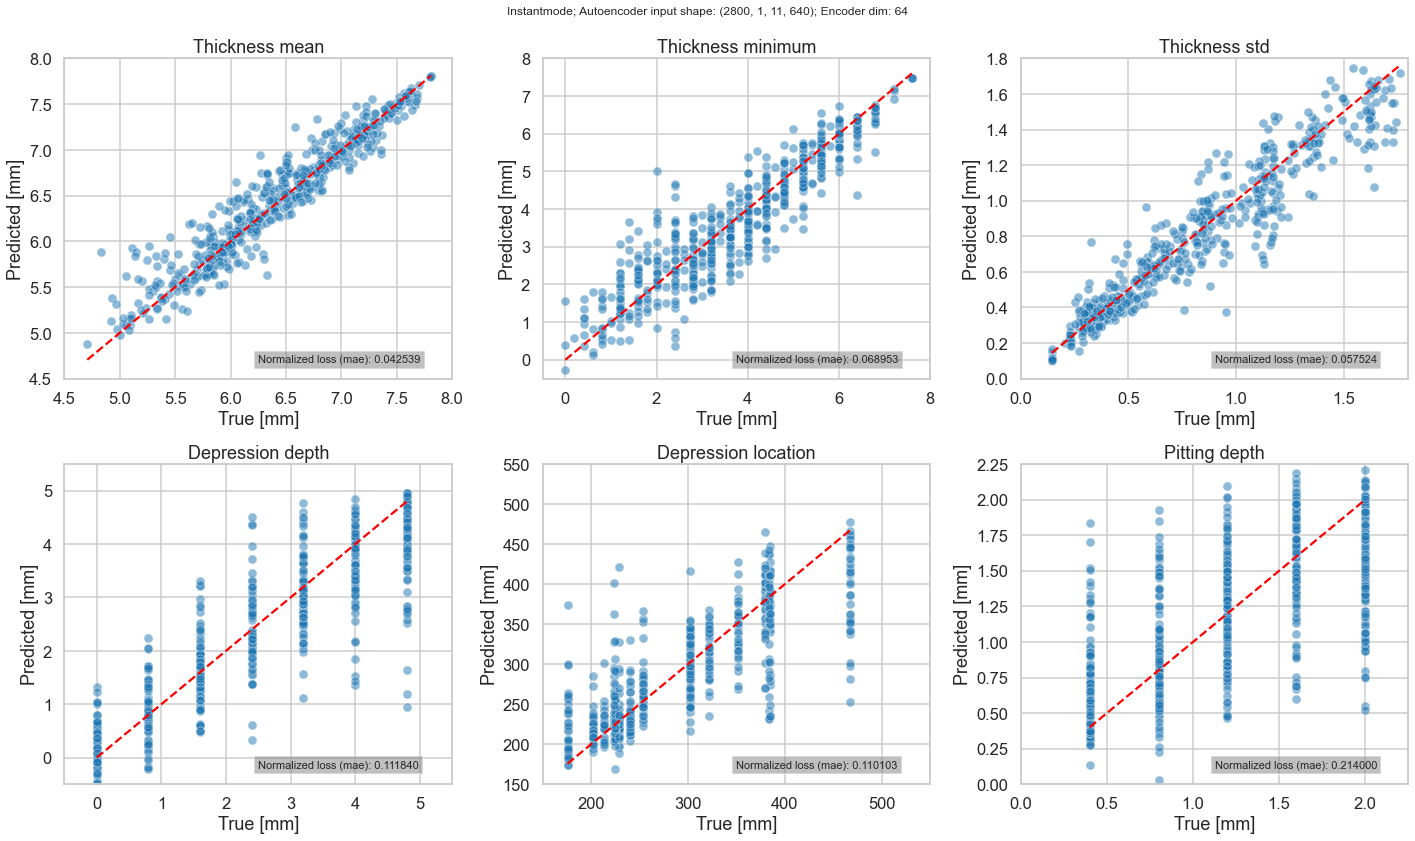

In [201]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False)

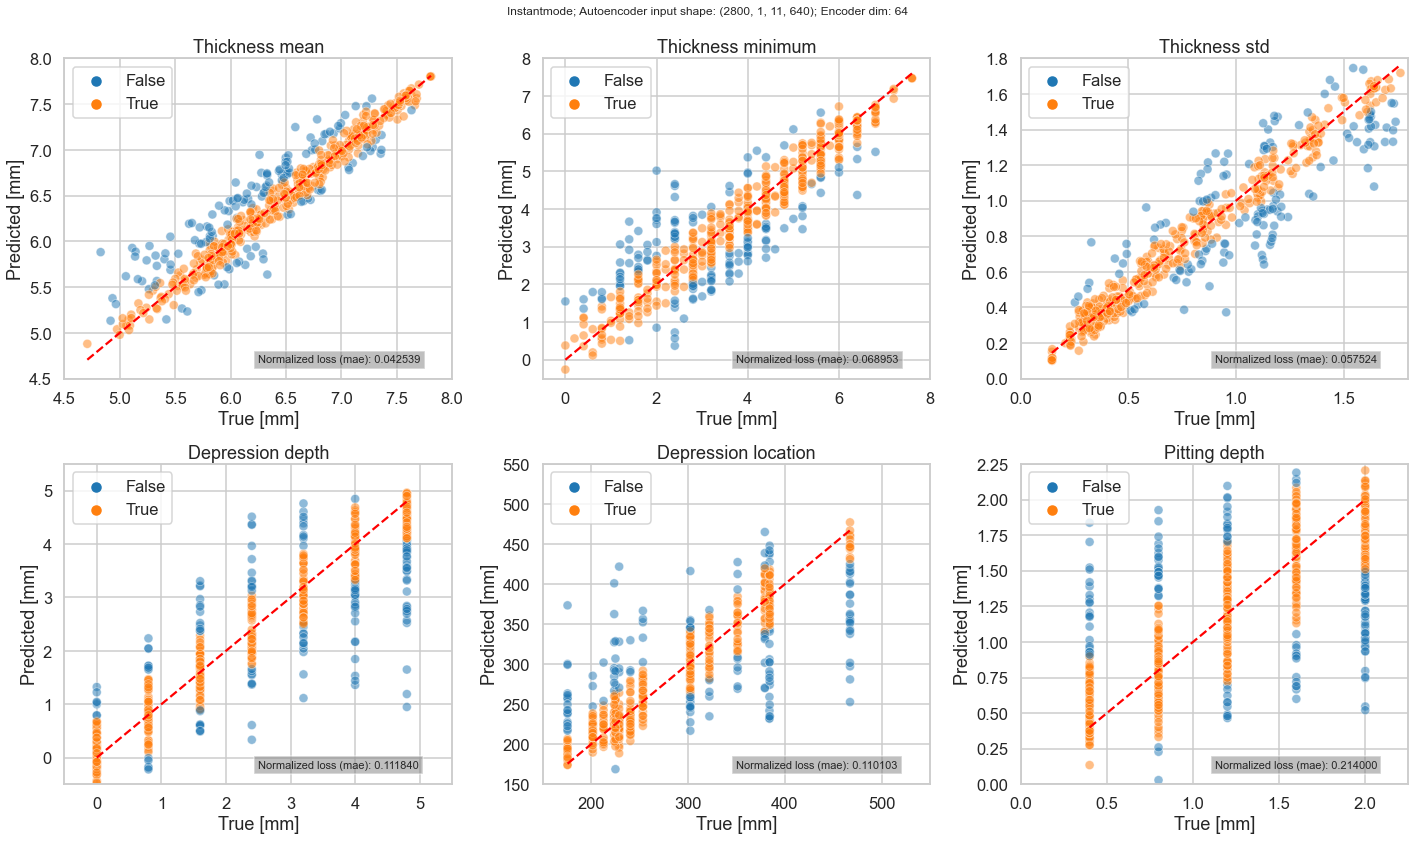

In [202]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=True)

# Extra QC

In [203]:
labels[(labels['Pitting depth'] == 10) & (labels['Depression depth'] == 24)]

,modelname,Thickness,seed,Depression depth,Pitting depth,Depression location,Depression width,Thickness maximum,Thickness minimum,Thickness mean,Thickness median,Thickness std,thickness_var
34,model_t032_s101_d024_p010,32,101,24,10,1756.336829,278.267035,32,1,25.197627,29.0,7.889615,62.246026
69,model_t032_s102_d024_p010,32,102,24,10,1896.793779,320.394762,32,0,24.456308,28.0,8.096513,65.553517
104,model_t032_s103_d024_p010,32,103,24,10,1610.688163,119.686105,32,0,27.888889,30.0,5.863901,34.385335
139,model_t032_s104_d024_p010,32,104,24,10,1119.606839,141.319343,32,0,27.588542,30.0,6.268265,39.291145
174,model_t032_s105_d024_p010,32,105,24,10,1008.702588,183.402517,32,1,26.855903,30.0,6.839619,46.780388
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2659,model_t040_s112_d024_p010,40,112,24,10,1512.098719,306.121848,40,10,32.537616,36.0,8.102654,65.652999
2694,model_t040_s113_d024_p010,40,113,24,10,2336.230931,79.561440,40,10,36.490451,38.0,4.989821,24.898317
2729,model_t040_s114_d024_p010,40,114,24,10,1126.020039,397.498112,40,6,30.940972,35.0,8.543783,72.996225
2764,model_t040_s115_d024_p010,40,115,24,10,1202.847511,331.109760,40,8,32.075231,36.0,8.228475,67.707797


In [204]:
labels[(labels['seed'] == 104) & (labels['Thickness'] == 32)]

,modelname,Thickness,seed,Depression depth,Pitting depth,Depression location,Depression width,Thickness maximum,Thickness minimum,Thickness mean,Thickness median,Thickness std,thickness_var
105,model_t032_s104_d000_p002,32,104,0,2,1119.606839,141.319343,32,30,31.043981,31.0,0.725655,0.526574
106,model_t032_s104_d000_p004,32,104,0,4,1119.606839,141.319343,32,28,30.457465,31.0,1.132566,1.282705
107,model_t032_s104_d000_p006,32,104,0,6,1119.606839,141.319343,32,26,30.169271,30.0,1.439768,2.072931
108,model_t032_s104_d000_p008,32,104,0,8,1119.606839,141.319343,32,24,30.047164,30.0,1.626954,2.646979
109,model_t032_s104_d000_p010,32,104,0,10,1119.606839,141.319343,32,22,30.012731,30.0,1.692534,2.864671
110,model_t032_s104_d004_p002,32,104,4,2,1119.606839,141.319343,32,26,30.636285,31.0,1.251085,1.565213
111,model_t032_s104_d004_p004,32,104,4,4,1119.606839,141.319343,32,24,30.046586,30.0,1.544094,2.384226
112,model_t032_s104_d004_p006,32,104,4,6,1119.606839,141.319343,32,22,29.777199,30.0,1.758374,3.091879
113,model_t032_s104_d004_p008,32,104,4,8,1119.606839,141.319343,32,22,29.665509,30.0,1.888293,3.565652
114,model_t032_s104_d004_p010,32,104,4,10,1119.606839,141.319343,32,22,29.631076,30.0,1.938312,3.757054


In [205]:
case_idx = 122 #105, 122, 138

In [206]:
labels.iloc[case_idx]['modelname']

'model_t032_s104_d012_p006'

In [207]:
#X_case_n.shape

In [208]:
X_case_c = X[case_idx,:,:timesamples]/X.max()
#X_case_c = X[case_idx,:,:250]/X.max()
X_case_c = np.expand_dims(X_case_c, 0)


X_case_n = X_case_c + make_noise(noisedb, X_case_c.shape)

X_case_c = np.expand_dims(X_case_c, 0)
X_case_n = np.expand_dims(X_case_n, 0)

X_case_c = pick_sensors(X_case_c, sensorindex)
X_case_n = pick_sensors(X_case_n, sensorindex)

#X_case_n = np.expand_dims(X_case_n, 0)
X_case_n_flat = X_case_n.reshape(1, np.prod(X_case_n.shape))
X_case_decoded = autoencoder.predict(X_case_n_flat)
X_case_decoded_shaped = X_case_decoded.reshape(1, 1, X_case_n.shape[2], X_case_n.shape[3])

In [209]:
noisedb

-12

In [210]:
#X_case_c = X[case_idx,:,:640]/X.max()
#X_case_c = np.expand_dims(X_case_c, 0)
#X_case_c = np.expand_dims(X_case_c, 0)
#X_case_c = pick_sensors(X_case_c, sensorindex)
X_case_c.shape, X_case_n.shape

((1, 1, 11, 640), (1, 1, 11, 640))

In [211]:
#X_case_c.shape, X_case_flat.shape, X_case_decoded_shaped.shape

In [212]:
X_case_decoded.shape, X_case_decoded_shaped.shape

((1, 7040), (1, 1, 11, 640))

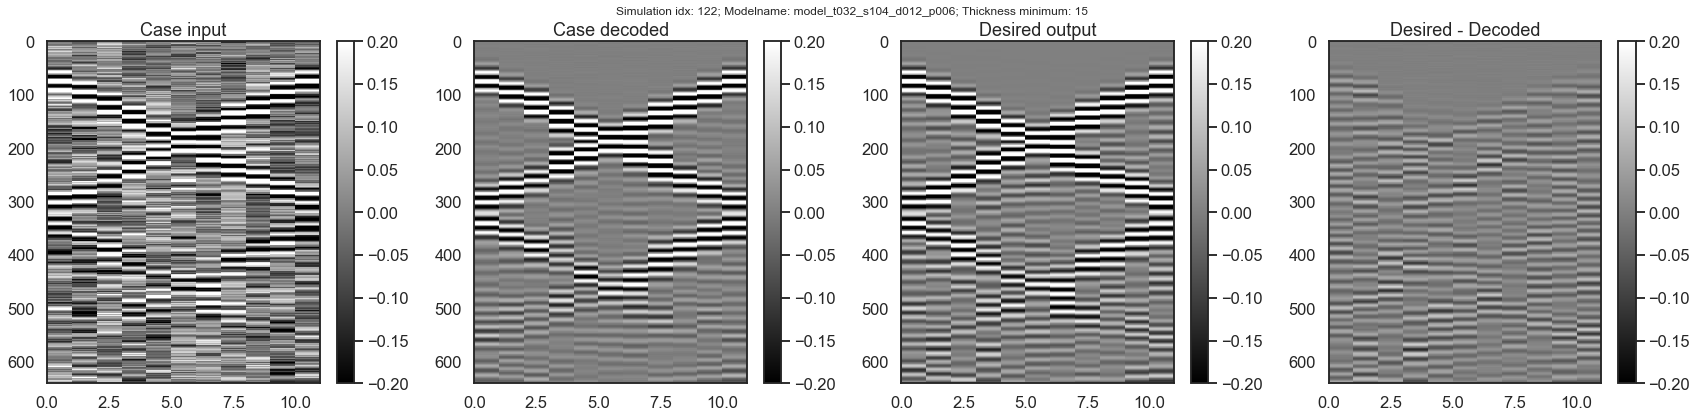

In [213]:
sns.set_style('white')
plt.figure(figsize=(24,6))
plt.grid(False)
plt.subplot(1, 4, 1)
plt.pcolormesh(X_case_n[0, 0, :, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
plt.grid(False)
plt.colorbar()
plt.title('Case input')
plt.clim([-0.2, 0.2])

plt.subplot(1, 4, 2)
plt.grid(False)
plt.pcolormesh(X_case_decoded_shaped[0, 0, :, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
plt.grid(False)
plt.colorbar()
plt.title('Case decoded')
plt.clim([-0.2, 0.2])

plt.subplot(1, 4, 3)
plt.grid(False)
plt.pcolormesh(X_case_c[0, 0, :, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
plt.grid(False)
plt.colorbar()
plt.title('Desired output')
plt.clim([-0.2, 0.2])

plt.subplot(1, 4, 4)
plt.grid(False)
plt.pcolormesh(X_case_c[0, 0, :, :].T - X_case_decoded_shaped[0, 0, :, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
plt.grid(False)
plt.colorbar()
plt.title('Desired - Decoded')
plt.clim([-0.2, 0.2])


plt.suptitle('Simulation idx: ' + str(case_idx) + 
             '; Modelname: ' + labels.iloc[case_idx]['modelname'] + 
             '; Thickness minimum: ' + str(labels.iloc[case_idx]['Thickness minimum']), fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.90)

plt.show()

# Real data

In [214]:
from realisticpipeml import read_data

In [215]:

realdatapath = '../data/input_real/Waveforms_clock_pos/'
df_waveforms, df_time = read_data.read_waveforms(realdatapath)

20220210-01oc-040kHz.csv
20220210-01oc-041kHz.csv
20220210-01oc-042kHz.csv
20220210-01oc-043kHz.csv
20220210-01oc-044kHz.csv
20220210-01oc-045kHz.csv
20220210-01oc-046kHz.csv
20220210-01oc-047kHz.csv
20220210-01oc-048kHz.csv
20220210-01oc-049kHz.csv
20220210-01oc-050kHz.csv
20220210-01oc-051kHz.csv
20220210-01oc-052kHz.csv
20220210-01oc-053kHz.csv
20220210-01oc-054kHz.csv
20220210-01oc-055kHz.csv
20220210-01oc-056kHz.csv
20220210-01oc-057kHz.csv
20220210-01oc-058kHz.csv
20220210-01oc-059kHz.csv
20220210-01oc-060kHz.csv
20220210-01oc-061kHz.csv
20220210-01oc-062kHz.csv
20220210-01oc-063kHz.csv
20220210-01oc-064kHz.csv
20220210-01oc-065kHz.csv
20220210-01oc-066kHz.csv
20220210-01oc-067kHz.csv
20220210-01oc-068kHz.csv
20220210-01oc-069kHz.csv
20220210-01oc-070kHz.csv
20220210-01oc-071kHz.csv
20220210-01oc-072kHz.csv
20220210-01oc-073kHz.csv
20220210-01oc-074kHz.csv
20220210-01oc-075kHz.csv
20220210-01oc-076kHz.csv
20220210-01oc-077kHz.csv
20220210-01oc-078kHz.csv
20220210-01oc-079kHz.csv


In [216]:
np.unique(df_waveforms.columns)

array(['040kHz', '041kHz', '042kHz', '043kHz', '044kHz', '045kHz',
       '046kHz', '047kHz', '048kHz', '049kHz', '050kHz', '051kHz',
       '052kHz', '053kHz', '054kHz', '055kHz', '056kHz', '057kHz',
       '058kHz', '059kHz', '060kHz', '061kHz', '062kHz', '063kHz',
       '064kHz', '065kHz', '066kHz', '067kHz', '068kHz', '069kHz',
       '070kHz', '071kHz', '072kHz', '073kHz', '074kHz', '075kHz',
       '076kHz', '077kHz', '078kHz', '079kHz', '080kHz'], dtype=object)

In [217]:
first_iter = True
for freq in np.unique(df_waveforms.columns):
  measurement_temp = df_waveforms[freq].to_numpy()[900:4100:5,:-1]
  measurement_temp = measurement_temp/measurement_temp.max()
  if first_iter:
    measurements = np.expand_dims(measurement_temp, axis=0)
    first_iter = False
  else:
    measurements = np.concatenate((measurements, np.expand_dims(measurement_temp, axis=0)), axis=0)


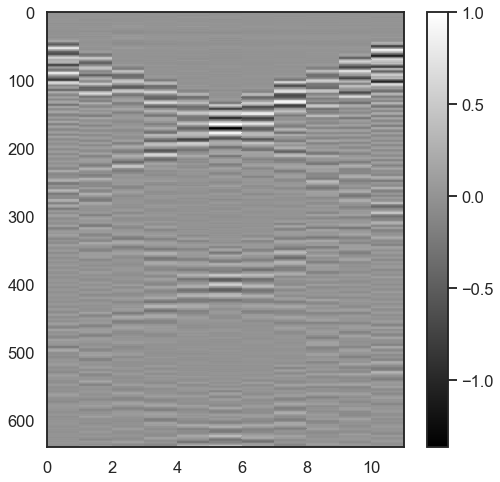

In [218]:
sns.set_style('white')
plt.figure(figsize=(8,8))
plt.pcolor(measurements[20,:,:], cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In [219]:
measurements_flat = measurements.reshape((len(measurements), np.prod(measurements.shape[1:])))
real_autoencoded = autoencoder.predict(measurements_flat)

In [220]:
real_autoencoded.shape, measurements.shape

((41, 7040), (41, 640, 11))

In [221]:
real_autoencoded_shaped = real_autoencoded.reshape(41, 11, 640)
real_autoencoded_shaped.shape

(41, 11, 640)

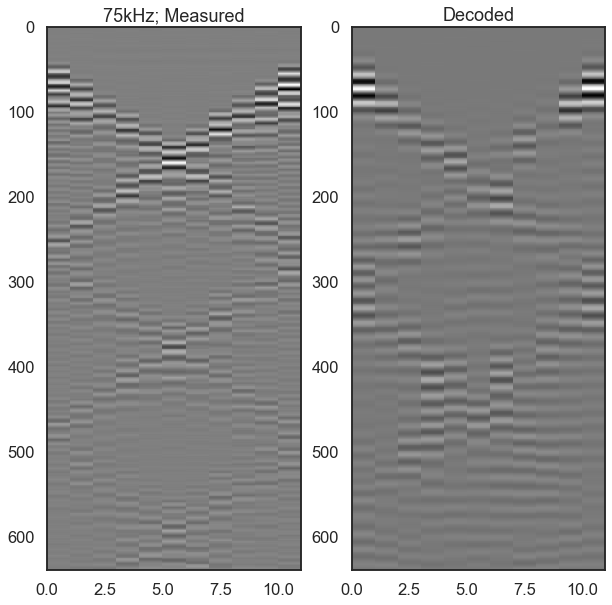

In [222]:
freq = 75
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.pcolormesh(measurements[freq-40,:,:], cmap='gray')
plt.gca().invert_yaxis()
plt.title(str(freq) + 'kHz; Measured')
plt.subplot(1,2,2)
plt.pcolormesh(real_autoencoded_shaped[freq-40,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.title('Decoded')
plt.show()

In [223]:
real_encoded = encoder.predict(measurements_flat)

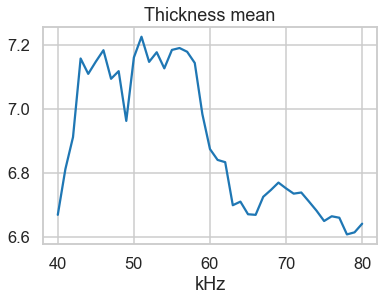

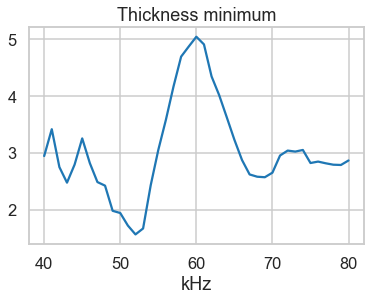

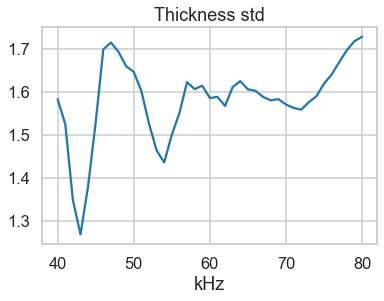

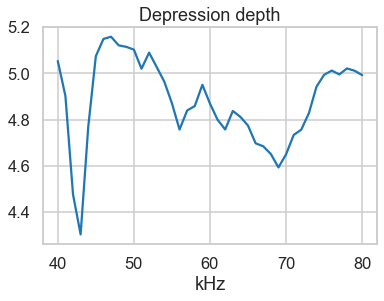

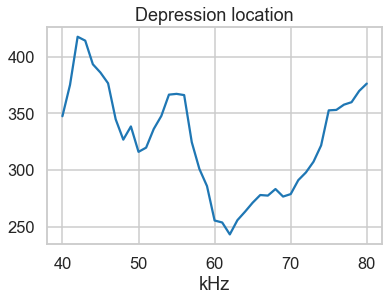

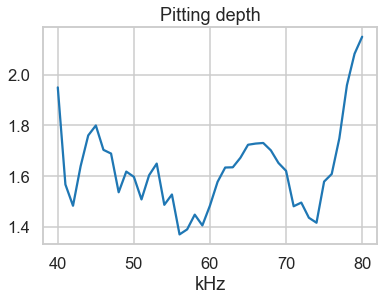

In [239]:
for attribute in attributes:
  real_prediction_norm = regression_models[attribute](real_encoded)

  real_prediction = min_max_scalers[attribute].inverse_transform(real_prediction_norm)
  plt.plot(real_prediction*dy)
  plt.title(attribute)
  plt.xticks(range(0, 41, 10), range(40, 81, 10))
  plt.xlabel('kHz')
  plt.show()

In [224]:
'''numplots = 4
sns.set_style('white')
plt.figure(figsize=(10, 4*numplots))
for i in range(1, numplots+1):
  plt.subplot(numplots,2,2*i-1)
  plt.pcolormesh(measurements[i*10,:,:], cmap='gray')
  #plt.yticks([])
  #plt.xticks([])
  plt.axis('off')
  plt.gca().invert_yaxis()
  plt.subplot(numplots,2,2*i)
  plt.pcolormesh(real_autoencoded_shaped[i*10,:,:].T, cmap='gray')
  #plt.yticks([])
  #plt.xticks([])
  plt.axis('off')
  plt.gca().invert_yaxis()
#plt.tight_layout()
plt.show()
'''

"numplots = 4\nsns.set_style('white')\nplt.figure(figsize=(10, 4*numplots))\nfor i in range(1, numplots+1):\n  plt.subplot(numplots,2,2*i-1)\n  plt.pcolormesh(measurements[i*10,:,:], cmap='gray')\n  #plt.yticks([])\n  #plt.xticks([])\n  plt.axis('off')\n  plt.gca().invert_yaxis()\n  plt.subplot(numplots,2,2*i)\n  plt.pcolormesh(real_autoencoded_shaped[i*10,:,:].T, cmap='gray')\n  #plt.yticks([])\n  #plt.xticks([])\n  plt.axis('off')\n  plt.gca().invert_yaxis()\n#plt.tight_layout()\nplt.show()\n"

In [225]:
stop

NameError: name 'stop' is not defined

# Direct Regression

In [ ]:
def make_direct_regressor():
  model = Sequential()
  model.add(Dense(x_train_flat.shape[1], activation='tanh'))
  model.add(Dense(1024, activation='tanh'))
  model.add(Dense(512, activation='tanh'))
  model.add(Dense(128, activation='tanh'))
  model.add(Dense(64, activation='tanh'))
  model.add(Dense(32, activation='tanh'))
  model.add(Dense(24, activation='tanh'))
  model.add(Dense(16, activation='tanh'))
  model.add(Dense(8, activation='tanh'))
  model.add(Dense(4, activation='tanh'))
  model.add(Dense(1, activation='linear'))
  return model

In [ ]:
sns.set_style('whitegrid')
df_loss = pd.DataFrame(columns=attributes)
df_test = pd.DataFrame(columns=attributes)
df_predict = pd.DataFrame(columns=attributes)
for attribute in attributes:
  print(attribute)
  y_reg = label_sample[[attribute]]

  min_max_scaler = MinMaxScaler()
  y_reg = min_max_scaler.fit_transform(y_reg)
  x_reg_train, x_reg_test, y_reg_train, y_reg_test_norm = train_test_split(X_sample_n, y_reg, test_size=0.2, random_state=42)
  x_reg_train_flat = x_reg_train.reshape((len(x_reg_train), np.prod(x_reg_train.shape[1:])))
  x_reg_test_flat = x_reg_test.reshape((len(x_reg_test), np.prod(x_reg_test.shape[1:])))
  direct_regression_model = make_regression_model()
  direct_regression_model.compile(loss='mae', optimizer='adam')
  history = direct_regression_model.fit(x_reg_train_flat, y_reg_train.astype('float32'),
                epochs=50,
                batch_size=20,
                shuffle=True,
                verbose=0,
                validation_data=(x_reg_test_flat, y_reg_test_norm.astype('float32')))

  plt.figure(figsize=(6, 4))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Loss', 'Validation loss'])
  plt.title(attribute)
  plt.show()

  y_predict_norm = direct_regression_model.predict(x_reg_test_flat)
  y_predict = min_max_scaler.inverse_transform(y_predict_norm)
  y_reg_test = min_max_scaler.inverse_transform(y_reg_test_norm)
  loss = direct_regression_model.evaluate(x_reg_test_flat, y_reg_test_norm)
  print("loss: " + str(loss))
  df_loss.at[0, attribute] = loss
  df_test[attribute] = np.squeeze(y_reg_test)
  df_predict[attribute] = np.squeeze(y_predict)

In [ ]:
plot_reg_results(df_test, df_predict, df_loss, df_scales)

In [ ]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False)